# Bike Sharing Demand ‚Äî Classical Baselines + LSTM (Structured)
*Merged & cleaned on 2025-08-27 20:39:08*

Î≥∏ ÎÖ∏Ìä∏Î∂ÅÏùÄ Îëê Í∞úÏùò ÏõêÎ≥∏ÏùÑ ÌÜµÌï©ÌïòÍ≥†, Ï§ëÎ≥µ ÏΩîÎìúÎ•º Ï†úÍ±∞Ìïú Îí§ Ïã§Ìñâ ÏàúÏÑúÏóê ÎßûÍ≤å Ïû¨Íµ¨ÏÑ±ÌñàÏäµÎãàÎã§.

## Table of Contents
1. [Setup & Imports](#setup-imports)
2. [Utilities](#utilities)
3. [Data Loading](#data-loading)
4. [Feature Engineering](#feature-engineering)
5. [Windowing & Scaling](#windowing-scaling)
6. [Classical Baselines](#classical-baselines)
7. [LSTM Modeling](#lstm-modeling)
8. [Training & Evaluation](#training-evaluation)
9. [Residual Analysis](#residual-analysis)


## Setup & Imports  {#setup-imports}

## Utilities  {#utilities}
Í≥µÌÜµÏúºÎ°ú ÏÇ¨Ïö©ÌïòÎäî Ìï®Ïàò/ÌÅ¥ÎûòÏä§Î•º Ìïú Í≥≥Ïóê Î™®ÏïòÏäµÎãàÎã§.

## Data Loading  {#data-loading}

### 1. Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ Î∞è Ï†ÑÏ≤òÎ¶¨
- `bike-sharing-demand/train.csv` Î°úÎìú, `datetime` ÌååÏã±/Ï†ïÎ†¨
- ÏãúÍ∞Ñ ÌååÏÉùÎ≥ÄÏàò ÏÉùÏÑ±(ÎÖÑ/Ïõî/Ïùº/ÏöîÏùº/ÏãúÍ∞Ñ)
- ÏãúÍ∞Ñ ÏàúÏÑúÎåÄÎ°ú train/val/test Î∂ÑÌï†


In [2]:
def load_hourly_data():
    path = '/Users/kimjinseok/Desktop/metacode-lecture/bike-sharing-demand/train.csv'
    if not os.path.exists(path):
        raise FileNotFoundError('train.csv Í≤ΩÎ°úÎ•º Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.')
    df = pd.read_csv(path)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime').reset_index(drop=True)
    cols = ['datetime','season','holiday','workingday','weather','temp','atemp','humidity','windspeed','casual','registered','count']
    return df[cols]


def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out['year'] = out['datetime'].dt.year
    out['month'] = out['datetime'].dt.month
    out['day'] = out['datetime'].dt.day
    out['dayofweek'] = out['datetime'].dt.dayofweek
    out['hour'] = out['datetime'].dt.hour
    return out


def split_by_time(df: pd.DataFrame, train_ratio: float = 0.8, val_ratio: float = 0.1):
    n = len(df)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    train = df.iloc[:n_train]
    val = df.iloc[n_train:n_train+n_val]
    test = df.iloc[n_train+n_val:]
    return train, val, test


df = load_hourly_data()
print('Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞:', df.shape, 'Í∏∞Í∞Ñ:', df['datetime'].min(), '‚Üí', df['datetime'].max())
df_feat = add_time_features(df)
train_df, val_df, test_df = split_by_time(df_feat)


Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: (10886, 12) Í∏∞Í∞Ñ: 2011-01-01 00:00:00 ‚Üí 2012-12-19 23:00:00


### 1. Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ Î∞è Ï†ÑÏ≤òÎ¶¨
- `bike-sharing-demand/train.csv` Î°úÎìú, ÏãúÍ∞Ñ ÌååÏÉùÎ≥ÄÏàò ÏÉùÏÑ±
- train/val/test ÏãúÍ∞Ñ Î∂ÑÌï†


In [55]:
def load_hourly_data():
    path = '/Users/kimjinseok/Desktop/metacode-lecture/bike-sharing-demand/train.csv'
    if not os.path.exists(path):
        raise FileNotFoundError('train.csv Í≤ΩÎ°úÎ•º Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.')
    df = pd.read_csv(path)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime').reset_index(drop=True)
    return df


def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out['year'] = out['datetime'].dt.year
    out['month'] = out['datetime'].dt.month
    out['day'] = out['datetime'].dt.day
    out['dayofweek'] = out['datetime'].dt.dayofweek
    out['hour'] = out['datetime'].dt.hour
    return out


def split_by_time(df: pd.DataFrame, train_ratio: float = 0.8, val_ratio: float = 0.1):
    n = len(df)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    train = df.iloc[:n_train]
    val = df.iloc[n_train:n_train+n_val]
    test = df.iloc[n_train+n_val:]
    return train, val, test


def build_feature_matrix(df: pd.DataFrame):
    feature_cols = ['temp','atemp','humidity','windspeed','season','holiday','workingday','weather','year','month','dayofweek','hour']
    X = df[feature_cols].to_numpy(dtype=np.float32)
    y = df['count'].astype(np.float32).to_numpy()
    return X, y, feature_cols


df = load_hourly_data()
print('Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞:', df.shape, 'Í∏∞Í∞Ñ:', df['datetime'].min(), '‚Üí', df['datetime'].max())
df = add_time_features(df)
# Í≤∞Ï∏°Ïπò Î≥¥Í∞Ñ: Î®ºÏ†Ä forward-fill, ÎÇ®ÏùÄ Í∞íÏùÄ back-fill
df = df.ffill().bfill()
train_df, val_df, test_df = split_by_time(df)


Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: (10886, 12) Í∏∞Í∞Ñ: 2011-01-01 00:00:00 ‚Üí 2012-12-19 23:00:00


## Feature Engineering  {#feature-engineering}

In [ ]:
def to_supervised_features(df: pd.DataFrame, target: str = 'count'):
    feature_cols = ['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','year','month','day','dayofweek','hour']
    X = df[feature_cols].copy()
    X = pd.get_dummies(X, columns=['season','holiday','workingday','weather','year','month','dayofweek','hour'], drop_first=False)
    y = df[target].astype(float)
    return X, y


def compute_metrics(y_true, y_pred):
    mae = float(mean_absolute_error(y_true, y_pred))
    mse = float(mean_squared_error(y_true, y_pred))
    rmse = float(np.sqrt(mse))

    var_y = float(np.var(y_true))
    if var_y < 1e-12:
        r2 = 1.0 if mse < 1e-12 else 0.0
    else:
        r2 = float(1.0 - mse / var_y)

    print("[Metrics]")
    print(f"MAE  : {mae:.6f} - ÌèâÍ∑† Ï†àÎåÄ Ïò§Ï∞®")
    print(f"MSE  : {mse:.6f} - ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®")
    print(f"RMSE : {rmse:.6f} - Ï†úÍ≥±Í∑º ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®")
    print(f"R^2  : {r2:.6f} - Í≤∞Ï†ïÍ≥ÑÏàò(ÏÑ§Î™ÖÎêú Î∂ÑÏÇ∞ ÎπÑÏú®)")

    return mae, mse, rmse, r2


def plot_actual_vs_pred(dt_index, y_true, y_pred, title):
    plt.figure(figsize=(12,4))
    plt.plot(dt_index, y_true, label='Actual')
    plt.plot(dt_index, y_pred, label='Pred')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.show()


# Î∂ÑÌï†Î≥Ñ ÌäπÏßï ÏÉùÏÑ±
X_train, y_train = to_supervised_features(train_df)
X_val, y_val     = to_supervised_features(val_df)
X_test, y_test   = to_supervised_features(test_df)

# ÌïôÏäµ Ïª¨ÎüºÏóê ÎßûÏ∂∞ Ï†ïÎ†¨/Î≥¥Ï†ï (ÏóÜÎäî Ïª¨ÎüºÏùÄ 0 Ï±ÑÏõÄ)
X_val  = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

[Metrics]
MAE  : 112.461157 - ÌèâÍ∑† Ï†àÎåÄ Ïò§Ï∞®
MSE  : 21701.572466 - ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®
RMSE : 147.314536 - Ï†úÍ≥±Í∑º ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®
R^2  : 0.611101 - Í≤∞Ï†ïÍ≥ÑÏàò(ÏÑ§Î™ÖÎêú Î∂ÑÏÇ∞ ÎπÑÏú®)
Linear/VAL (112.46115659982183, 21701.5724664791, 147.3145358288825, 0.6111009463256456)
[Metrics]
MAE  : 84.412417 - ÌèâÍ∑† Ï†àÎåÄ Ïò§Ï∞®
MSE  : 12720.204474 - ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®
RMSE : 112.783884 - Ï†úÍ≥±Í∑º ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®
R^2  : 0.662295 - Í≤∞Ï†ïÍ≥ÑÏàò(ÏÑ§Î™ÖÎêú Î∂ÑÏÇ∞ ÎπÑÏú®)
Linear/TEST (84.41241701047062, 12720.204474477732, 112.78388393062961, 0.6622946885094285)


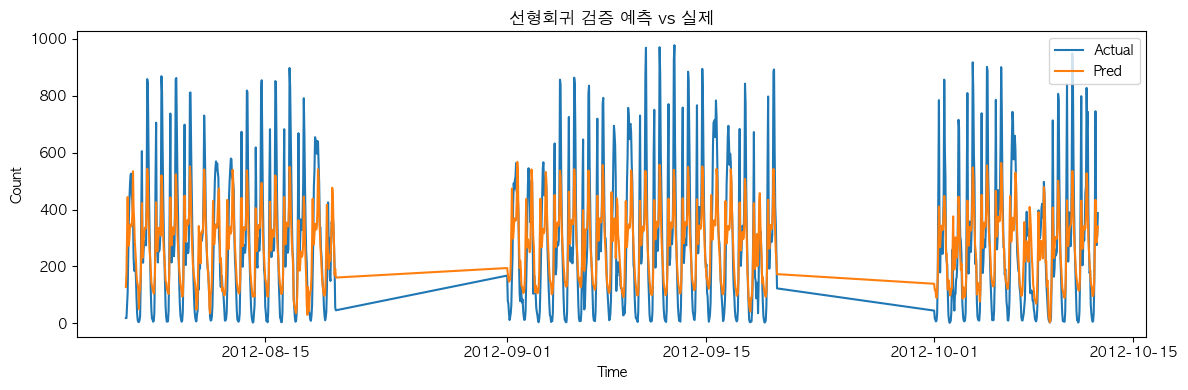

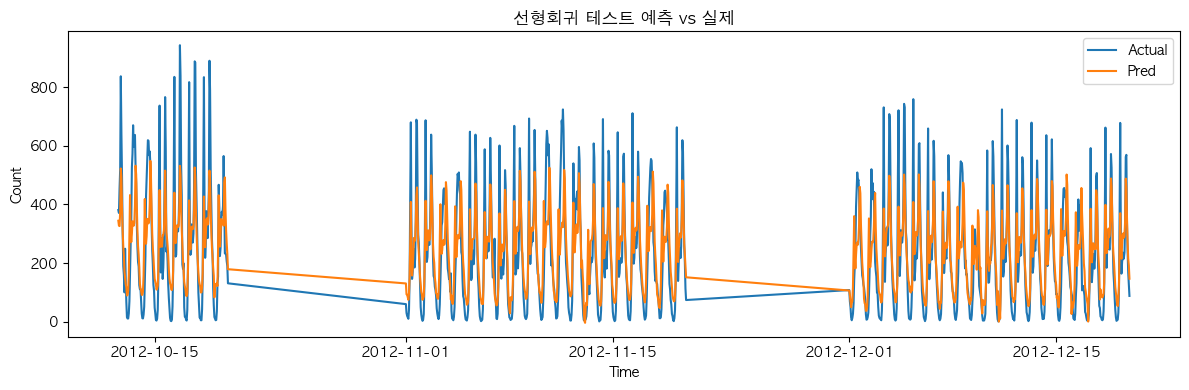

[Metrics]
MAE  : 59.311357 - ÌèâÍ∑† Ï†àÎåÄ Ïò§Ï∞®
MSE  : 8326.449294 - ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®
RMSE : 91.249380 - Ï†úÍ≥±Í∑º ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®
R^2  : 0.850787 - Í≤∞Ï†ïÍ≥ÑÏàò(ÏÑ§Î™ÖÎêú Î∂ÑÏÇ∞ ÎπÑÏú®)
RF/VAL (59.31135723039216, 8326.449294475082, 91.2493796936455, 0.8507873908173891)
[Metrics]
MAE  : 68.762976 - ÌèâÍ∑† Ï†àÎåÄ Ïò§Ï∞®
MSE  : 10117.330518 - ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®
RMSE : 100.584942 - Ï†úÍ≥±Í∑º ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®
R^2  : 0.731398 - Í≤∞Ï†ïÍ≥ÑÏàò(ÏÑ§Î™ÖÎêú Î∂ÑÏÇ∞ ÎπÑÏú®)
RF/TEST (68.76297553516821, 10117.330518318044, 100.58494180700232, 0.7313976940388812)


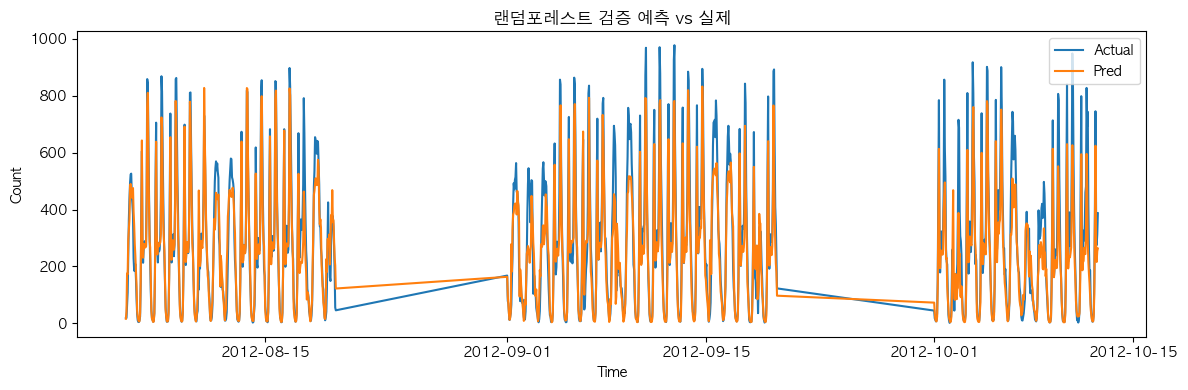

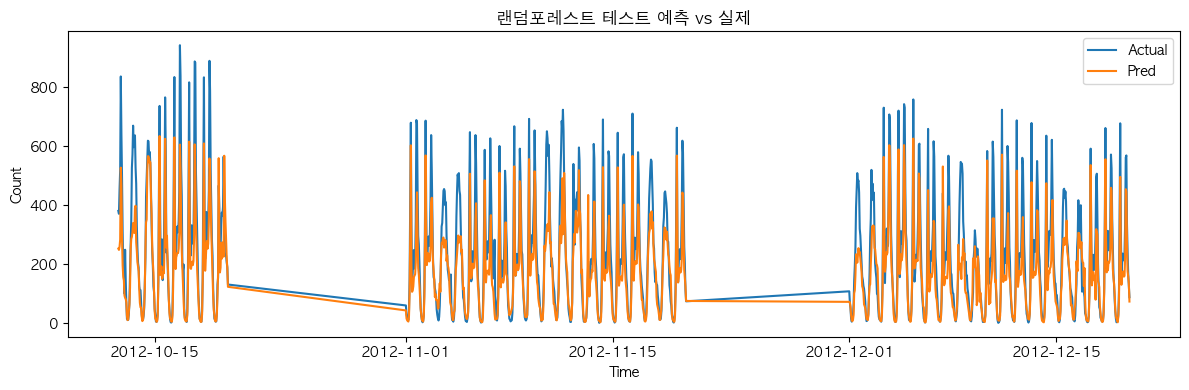

RF Ï§ëÏöîÎèÑ TOP 15:
 atemp           0.186645
hour_17         0.094062
humidity        0.084904
hour_18         0.079720
hour_8          0.055163
workingday_0    0.047907
workingday_1    0.047481
temp            0.041277
year_2011       0.030997
year_2012       0.030407
hour_19         0.030261
hour_7          0.016440
hour_2          0.015388
hour_1          0.015234
day             0.014464
dtype: float64


In [4]:


from sklearn.linear_model import LinearRegression
lin = LinearRegression().fit(X_train, y_train)
lin_val_pred  = lin.predict(X_val)
lin_test_pred = lin.predict(X_test)

print('Linear/VAL', compute_metrics(y_val.to_numpy(), lin_val_pred))
print('Linear/TEST', compute_metrics(y_test.to_numpy(), lin_test_pred))
plot_actual_vs_pred(val_df['datetime'].values, y_val.to_numpy(), lin_val_pred, 'ÏÑ†ÌòïÌöåÍ∑Ä Í≤ÄÏ¶ù ÏòàÏ∏° vs Ïã§Ï†ú')
plot_actual_vs_pred(test_df['datetime'].values, y_test.to_numpy(), lin_test_pred, 'ÏÑ†ÌòïÌöåÍ∑Ä ÌÖåÏä§Ìä∏ ÏòàÏ∏° vs Ïã§Ï†ú')

rf = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
rf_val_pred = rf.predict(X_val)
rf_test_pred = rf.predict(X_test)
print('RF/VAL', compute_metrics(y_val.to_numpy(), rf_val_pred))
print('RF/TEST', compute_metrics(y_test.to_numpy(), rf_test_pred))
plot_actual_vs_pred(val_df['datetime'].values, y_val.to_numpy(), rf_val_pred, 'ÎûúÎç§Ìè¨Î†àÏä§Ìä∏ Í≤ÄÏ¶ù ÏòàÏ∏° vs Ïã§Ï†ú')
plot_actual_vs_pred(test_df['datetime'].values, y_test.to_numpy(), rf_test_pred, 'ÎûúÎç§Ìè¨Î†àÏä§Ìä∏ ÌÖåÏä§Ìä∏ ÏòàÏ∏° vs Ïã§Ï†ú')

try:
    importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    print('RF Ï§ëÏöîÎèÑ TOP 15:\n', importances.head(15))
except Exception:
    pass


In [5]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 0) Ï†ÑÏ≤¥ ÌîºÏ≤ò/ÌÉÄÍπÉ ÏÉùÏÑ±
X_all_ts, y_all_ts = to_supervised_features(df_feat)

# (ÏÑ†ÌÉù) ÏãúÍ∞Ñ Ïù∏Îç±Ïä§ Ï†ïÎ†¨Ïù¥ ÌïÑÏöîÌïòÎ©¥ ÏÇ¨Ïö©
# X_all_ts = X_all_ts.sort_index()
# y_all_ts = y_all_ts.loc[X_all_ts.index]

# 1) ÌôÄÎìúÏïÑÏõÉ Î∂ÑÌï†: ÎßàÏßÄÎßâ 20%Î•º ÏµúÏ¢Ö ÌÖåÏä§Ìä∏Î°ú Î≥¥Ï°¥
split_idx = int(len(X_all_ts) * 0.8)
X_cv_ts,  y_cv_ts   = X_all_ts.iloc[:split_idx], y_all_ts.iloc[:split_idx]   # ‚Üê ÍµêÏ∞®Í≤ÄÏ¶ù(ÌäúÎãù) Íµ¨Í∞Ñ
X_test_ts, y_test_ts = X_all_ts.iloc[split_idx:], y_all_ts.iloc[split_idx:]  # ‚Üê ÏµúÏ¢Ö ÌÖåÏä§Ìä∏ Íµ¨Í∞Ñ (ÏãúÍ≥ÑÏó¥ ÌÖåÏä§Ìä∏ÏÖã)

print(f"[SHAPE] X_cv_ts={X_cv_ts.shape}, y_cv_ts={y_cv_ts.shape}, "
      f"X_test_ts={X_test_ts.shape}, y_test_ts={y_test_ts.shape}")

# 2) ÏãúÍ≥ÑÏó¥ ÍµêÏ∞®Í≤ÄÏ¶ù Î∂ÑÌï†Í∏∞ (CV Ï†ÑÏö©)
tscv_cv = TimeSeriesSplit(n_splits=5)

# 3) ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Í∑∏Î¶¨Îìú & Î™®Îç∏/ÏÑúÏπò Í∞ùÏ≤¥ (CV Ï†ÑÏö©)
param_grid_rf = {"n_estimators": [200, 300], "max_depth": [None, 12, 24]}
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_gs_cv = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid_rf,
    cv=tscv_cv,
    scoring='neg_root_mean_squared_error',  # RMSEÏùò ÏùåÏàò
    n_jobs=-1
)

# 4) CV Íµ¨Í∞ÑÏúºÎ°ú Í∑∏Î¶¨ÎìúÏÑúÏπò Ïã§Ìñâ
rf_gs_cv.fit(X_cv_ts, y_cv_ts)

print('ÏµúÏ†Å ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞(CV):', rf_gs_cv.best_params_)
print('CV RMSE:', -rf_gs_cv.best_score_)

# 5) ÏµúÏ†Å Î™®Îç∏ÏùÑ CV Íµ¨Í∞Ñ Ï†ÑÏ≤¥Î°ú Ïû¨ÌïôÏäµ (Ïû¨Ï†ÅÌï©)
rf_best_cv_ts = rf_gs_cv.best_estimator_
rf_best_cv_ts.fit(X_cv_ts, y_cv_ts)

# 6) ÏµúÏ¢Ö ÏãúÍ≥ÑÏó¥ ÌÖåÏä§Ìä∏ ÌèâÍ∞Ä
y_pred_test_ts = rf_best_cv_ts.predict(X_test_ts)

mae_ts = mean_absolute_error(y_test_ts, y_pred_test_ts)
mse_ts = mean_squared_error(y_test_ts, y_pred_test_ts)
rmse_ts = np.sqrt(mse_ts)
r2_ts = r2_score(y_test_ts, y_pred_test_ts)

print("\n[TEST Metrics - Time Series Holdout]")
print(f"MAE  : {mae_ts:.3f}")
print(f"MSE  : {mse_ts:.3f}")
print(f"RMSE : {rmse_ts:.3f}")
print(f"R^2  : {r2_ts:.3f}")



[SHAPE] X_cv_ts=(8708, 62), y_cv_ts=(8708,), X_test_ts=(2178, 62), y_test_ts=(2178,)
ÏµúÏ†Å ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞(CV): {'max_depth': None, 'n_estimators': 200}
CV RMSE: 93.78490562597392

[TEST Metrics - Time Series Holdout]
MAE  : 63.831
MSE  : 9158.992
RMSE : 95.703
R^2  : 0.807


In [ ]:
def train_model(model, train_loader, val_loader, epochs: int, lr: float, device):
    criterion = nn.MSELoss()
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, patience=3)
    patience = 8
    no_improve = 0
    best_val = float('inf')
    best_state = None
    for ep in range(1, epochs+1):
        model.train()
        tr_sum, n = 0.0, 0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            optim.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optim.step()
            tr_sum += float(loss.item()) * len(xb)
            n += len(xb)
        tr_loss = tr_sum / max(n, 1)

        model.eval()
        with torch.no_grad():
            va_sum, n2 = 0.0, 0
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                va_sum += float(loss.item()) * len(xb)
                n2 += len(xb)
        va_loss = va_sum / max(n2, 1)
        print(f'Epoch {ep:03d} - train MSE: {tr_loss:.4f}, val MSE: {va_loss:.4f}')
        scheduler.step(va_loss)
        if va_loss + 1e-9 < best_val:
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f'[EarlyStop] epoch={ep} val={va_loss:.5f}')
                break
        if va_loss < best_val:
            best_val = va_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    if best_state is not None:
        model.load_state_dict(best_state)


def predict_all(model, loader, device):
    model.eval()
    outs = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(device)
            pred = model(xb)
            outs.append(pred.cpu().numpy())
    return np.concatenate(outs, axis=0)


def plot_series(dt_index, y_true, y_pred, title):
    plt.figure(figsize=(12,4))
    plt.plot(dt_index, y_true, label='Actual')
    plt.plot(dt_index, y_pred, label='Pred')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.show()


# Îç∞Ïù¥ÌÑ∞ Íµ¨ÏÑ± Î∞è ÌïôÏäµ
# 3Í∞ÄÏßÄ Í∞úÏÑ† Ï†ÅÏö©: Ï£ºÍ∞Ñ Ï∞Ω(168), ÏãúÍ∞Ñ ÏõêÌòï Ïù∏ÏΩîÎî©, Î°úÍ∑∏ ÌÉÄÍπÉ

def add_cyclical_cols(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out['hour_sin'] = np.sin(2*np.pi*out['hour']/24)
    out['hour_cos'] = np.cos(2*np.pi*out['hour']/24)
    return out

train_df = add_cyclical_cols(train_df)
val_df   = add_cyclical_cols(val_df)
test_df  = add_cyclical_cols(test_df)

X_train, y_train, feat_cols = build_feature_matrix(train_df)
X_val,   y_val,   _         = build_feature_matrix(val_df)
X_test,  y_test,  _         = build_feature_matrix(test_df)

# ÏãúÍ∞Ñ ÏõêÌòï Ïù∏ÏΩîÎî©ÏùÑ XÏóê Ï∂îÍ∞Ä(Í∏∞Ï°¥ Ìï®ÏàòÎäî ÏàòÏ†ïÌïòÏßÄ ÏïäÍ≥† Î∞∞Ïó¥Ïóê Ïù¥Ïñ¥Î∂ôÏûÑ)
def append_cols(X: np.ndarray, df: pd.DataFrame, cols: list[str]) -> np.ndarray:
    return np.concatenate([X, df[cols].to_numpy(dtype=np.float32)], axis=1)

X_train = append_cols(X_train, train_df, ['hour_sin','hour_cos'])
X_val   = append_cols(X_val,   val_df,   ['hour_sin','hour_cos'])
X_test  = append_cols(X_test,  test_df,  ['hour_sin','hour_cos'])

# ÌëúÏ§ÄÌôî (train Í∏∞Ï§Ä)
mean = X_train.mean(axis=0, keepdims=True)
std  = X_train.std(axis=0, keepdims=True) + 1e-8
X_train = (X_train - mean) / std
X_val   = (X_val   - mean) / std
X_test  = (X_test  - mean) / std

# Î°úÍ∑∏ ÌÉÄÍπÉ Ï†ÅÏö©
use_log_target = True
if use_log_target:
    y_train = np.log1p(y_train)
    y_val   = np.log1p(y_val)
    y_test  = np.log1p(y_test)

# Ï£ºÍ∞Ñ Ìå®ÌÑ¥ÏùÑ ÌïôÏäµÌïòÎèÑÎ°ù Ï∞Ω ÌÅ¨Í∏∞ ÌôïÎåÄ
window = 168
Xtr_seq, ytr_seq = make_windows(X_train, y_train, window)
Xva_seq, yva_seq = make_windows(X_val,   y_val,   window)
Xte_seq, yte_seq = make_windows(X_test,  y_test,  window)

# AÎ∞©Î≤ï: ÌÅ¥ÎûòÏä§ ÏóÜÏù¥ Î¶¨Ïä§Ìä∏ Í∏∞Î∞ò Îç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú Íµ¨ÏÑ±
# 1) yÏùò ÎßàÏßÄÎßâ Ï∞®Ïõê Ï†úÍ±∞(ÌïÑÏöîÏãú)
ytr_1d = ytr_seq.squeeze(-1) if ytr_seq.ndim > 1 else ytr_seq
yva_1d = yva_seq.squeeze(-1) if yva_seq.ndim > 1 else yva_seq
yte_1d = yte_seq.squeeze(-1) if yte_seq.ndim > 1 else yte_seq

# 2) ÌÖêÏÑú Î≥ÄÌôò
a2_Xtr = torch.as_tensor(Xtr_seq, dtype=torch.float32)
a2_ytr = torch.as_tensor(ytr_1d,  dtype=torch.float32)
a2_Xva = torch.as_tensor(Xva_seq, dtype=torch.float32)
a2_yva = torch.as_tensor(yva_1d,  dtype=torch.float32)
a2_Xte = torch.as_tensor(Xte_seq, dtype=torch.float32)
a2_yte = torch.as_tensor(yte_1d,  dtype=torch.float32)

# 3) (x, y) ÌäúÌîå Î¶¨Ïä§Ìä∏Î°ú Î¨∂Í∏∞
train_data = list(zip(a2_Xtr, a2_ytr))
val_data   = list(zip(a2_Xva, a2_yva))
test_data  = list(zip(a2_Xte, a2_yte))

# 4) DataLoader Íµ¨ÏÑ± (drop_lastÎäî DataLoader Ïù∏Ïûê)
train_loader = DataLoader(train_data, batch_size=128, shuffle=False, drop_last=True)
val_loader   = DataLoader(val_data,   batch_size=256, shuffle=False)
test_loader  = DataLoader(test_data,  batch_size=256, shuffle=False)

_set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# ÌÅ¥ÎûòÏä§ ÏóÜÏù¥ nn.LSTM + nn.LinearÎ°ú ÌïôÏäµ/ÏòàÏ∏°
input_size = Xtr_seq.shape[-1]
lstm_nc, head_nc, _ = make_lstm_pair(input_size=input_size, hidden_size=64, num_layers=2, dropout=0.1, device=device)

params_nc = list(lstm_nc.parameters()) + list(head_nc.parameters())
optim_nc = torch.optim.Adam(params_nc, lr=1e-3)
crit_nc = nn.MSELoss()
scheduler_nc = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_nc, factor=0.5, patience=3)

best_val = float('inf')
best_state = None
patience = 8
no_improve = 0

for ep in range(1, 21):
    lstm_nc.train(); head_nc.train()
    tr_sum, n = 0.0, 0
    for xb, yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        pred = lstm_forward(lstm_nc, head_nc, xb)
        loss = crit_nc(pred, yb)
        optim_nc.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(params_nc, max_norm=1.0)
        optim_nc.step()
        tr_sum += float(loss.item()) * len(xb)
        n += len(xb)
    tr_loss = tr_sum / max(n, 1)

    lstm_nc.eval(); head_nc.eval()
    with torch.no_grad():
        va_sum, n2 = 0.0, 0
        for xb, yb in val_loader:
            xb = xb.to(device); yb = yb.to(device)
            pred = lstm_forward(lstm_nc, head_nc, xb)
            loss = crit_nc(pred, yb)
            va_sum += float(loss.item()) * len(xb)
            n2 += len(xb)
    va_loss = va_sum / max(n2, 1)
    print(f'Epoch {ep:03d} - train MSE: {tr_loss:.4f}, val MSE: {va_loss:.4f}')
    scheduler_nc.step(va_loss)
    if va_loss + 1e-9 < best_val:
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f'[EarlyStop] epoch={ep} val={va_loss:.5f}')
            break
    if va_loss < best_val:
        best_val = va_loss
        best_state = {
            'lstm': {k: v.detach().cpu().clone() for k, v in lstm_nc.state_dict().items()},
            'head': {k: v.detach().cpu().clone() for k, v in head_nc.state_dict().items()},
        }

if best_state is not None:
    lstm_nc.load_state_dict(best_state['lstm'])
    head_nc.load_state_dict(best_state['head'])

# ÏòàÏ∏°
with torch.no_grad():
    lstm_nc.eval(); head_nc.eval()
    outs_v = []
    for xb, _ in val_loader:
        xb = xb.to(device)
        pred = lstm_forward(lstm_nc, head_nc, xb)
        outs_v.append(pred.cpu().numpy())
    val_pred = np.concatenate(outs_v, axis=0)

with torch.no_grad():
    lstm_nc.eval(); head_nc.eval()
    outs_t = []
    for xb, _ in test_loader:
        xb = xb.to(device)
        pred = lstm_forward(lstm_nc, head_nc, xb)
        outs_t.append(pred.cpu().numpy())
    test_pred = np.concatenate(outs_t, axis=0)

val_idx = val_df['datetime'].iloc[window:].values
test_idx = test_df['datetime'].iloc[window:].values

# ÌîåÎ°ØÎèÑ Î°úÍ∑∏ Î≥µÏõê ÌõÑ ÌëúÏãú
if 'use_log_target' in globals() and use_log_target:
    plot_series(val_idx, np.expm1(yva_seq.squeeze(-1)), np.expm1(val_pred), 'LSTM Í≤ÄÏ¶ù ÏòàÏ∏° vs Ïã§Ï†ú')
    plot_series(test_idx, np.expm1(yte_seq.squeeze(-1)), np.expm1(test_pred), 'LSTM ÌÖåÏä§Ìä∏ ÏòàÏ∏° vs Ïã§Ï†ú')
else:
    plot_series(val_idx, yva_seq.squeeze(-1), val_pred, 'LSTM Í≤ÄÏ¶ù ÏòàÏ∏° vs Ïã§Ï†ú')
    plot_series(test_idx, yte_seq.squeeze(-1), test_pred, 'LSTM ÌÖåÏä§Ìä∏ ÏòàÏ∏° vs Ïã§Ï†ú')


## Windowing & Scaling  {#windowing-scaling}

In [1]:
# -*- coding: utf-8 -*-
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX

try:
    from prophet import Prophet
    _HAS_PROPHET = True
except Exception:
    _HAS_PROPHET = False

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message=r"Glyph.*missing from font.*", category=UserWarning)

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï Î∞è ÎßàÏù¥ÎÑàÏä§ Í∏∞Ìò∏ Íπ®Ïßê Î∞©ÏßÄ (ÌõÑÎ≥¥Íµ∞ÏùÑ sans-serif Ïö∞ÏÑ†ÏàúÏúÑÎ°ú ÏßÄÏ†ï)
def _set_korean_font() -> None:
    font_candidates = [
        "AppleGothic",
        "NanumGothic",
        "Malgun Gothic",
        "Noto Sans CJK KR",
        "Noto Sans KR",
        "DejaVu Sans",
    ]
    # Ïö∞ÏÑ†ÏàúÏúÑ Î¶¨Ïä§Ìä∏Î•º Í∑∏ÎåÄÎ°ú Îì±Î°ùÌïòÏó¨ ÏÇ¨Ïö© Í∞ÄÎä•Ìïú Ìï≠Î™©ÏúºÎ°ú ÎåÄÏ≤¥ÎêòÎèÑÎ°ù Ìï®
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = font_candidates
    plt.rcParams["axes.unicode_minus"] = False

_set_korean_font()

pd.set_option('display.max_columns', 100)


/Users/kimjinseok/Desktop/metacode-lecture/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## ÏûîÏ∞® Î∂ÑÏÑù Í≤∞Í≥º (Random Forest)

### 1. ÏûîÏ∞® ÏãúÍ≥ÑÏó¥ (Residual Time Series)
- ÏãúÍ∞Ñ Ï∂ïÏóê Îî∞Îùº ÏòàÏ∏° Ïò§Ï∞®(Ïã§Ï†úÍ∞í - ÏòàÏ∏°Í∞í)Î•º ÌëúÏãúÌïú Í∑∏ÎûòÌîÑ  
- **ÌäπÏßï**:
  - ÎåÄÎ∂ÄÎ∂Ñ ÏûîÏ∞®Í∞Ä 0 Í∑ºÏ≤òÏóê Î∂ÑÌè¨ÌïòÏßÄÎßå, Íµ¨Í∞ÑÎ≥ÑÎ°ú Î≠âÏπ® ÌòÑÏÉÅÏù¥ Î≥¥ÏûÑ
  - ÏùºÎ∂Ä ÏãúÏ†êÏóêÏÑú ÌÅ∞ ÏñëÏàò(Í≥ºÏÜåÏòàÏ∏°) ÎòêÎäî ÏùåÏàò(Í≥ºÎåÄÏòàÏ∏°) ÌîºÌÅ¨ Î∞úÏÉù
  - ÏôÑÏ†ÑÌûà Î¨¥ÏûëÏúÑ(white noise) ÌòïÌÉúÍ∞Ä ÏïÑÎãàÎ©∞, ÏãúÍ∞ÑÏóê Îî∞Î•∏ Íµ¨Ï°∞Ï†Å Ìå®ÌÑ¥Ïù¥ ÎÇ®ÏïÑ ÏûàÏùå  

üëâ **Ìï¥ÏÑù**:  
Î™®Îç∏Ïù¥ ÌèâÍ∑†Ï†ÅÏúºÎ°úÎäî Ïûò ÎßûÏ∂îÏßÄÎßå, **ÌäπÏ†ï ÏãúÏ†ê(Í∏âÎì±/Í∏âÎùΩ Íµ¨Í∞Ñ Îì±)**ÏóêÏÑúÎäî ÏòàÏ∏°Î†•Ïù¥ Îñ®Ïñ¥ÏßÄÎ©∞,  
Ïù¥Îäî Î™®Îç∏Ïù¥ **Í≥ÑÏ†àÏÑ±/Ï∂îÏÑ∏ Í∞ôÏùÄ ÏùºÎ∂Ä Ìå®ÌÑ¥ÏùÑ Ï∂©Î∂ÑÌûà Î∞òÏòÅÌïòÏßÄ Î™ªÌñàÏùåÏùÑ ÏãúÏÇ¨**Ìï®.

---

### 2. ÏûîÏ∞® Î∂ÑÌè¨ (Residual Histogram)
- ÏûîÏ∞® Í∞íÏùò ÎπàÎèÑ Î∂ÑÌè¨Î•º ÎÇòÌÉÄÎÇ∏ Í∑∏ÎûòÌîÑ  
- **ÌäπÏßï**:
  - Ï§ëÏã¨Ïù¥ 0 Í∑ºÏ≤òÏóê ÏûàÏúºÎ©∞, ÎåÄÏ≤¥Î°ú Ï¢åÏö∞ ÎåÄÏπ≠Ïóê Í∞ÄÍπåÏö¥ ÌòïÌÉú
  - Îã§Îßå Ïò§Î•∏Ï™Ω Íº¨Î¶¨(ÏñëÏùò ÏûîÏ∞®)Í∞Ä Ï°∞Í∏à Îçî Í∏∏Ïñ¥ Ïã§Ï†úÎ≥¥Îã§ ÏûëÍ≤å ÏòàÏ∏°ÌïòÎäî Í≤ΩÌñ•Ïù¥ ÏùºÎ∂Ä Ï°¥Ïû¨
  - ÎåÄÎ∂ÄÎ∂Ñ ÏûîÏ∞®Îäî -100 ~ +200 Íµ¨Í∞ÑÏóê Î∂ÑÌè¨, ÏÜåÏàòÏùò Í∑πÎã®Í∞í(¬±200~400) Ï°¥Ïû¨  

üëâ **Ìï¥ÏÑù**:  
ÏûîÏ∞® Î∂ÑÌè¨Îäî ÎåÄÏ≤¥Î°ú Ï†ïÍ∑úÎ∂ÑÌè¨Ïóê Í∞ÄÍπåÏõå **ÌÅ∞ Ìé∏Ìñ•ÏùÄ ÏóÜÏßÄÎßå**,  
ÏïΩÍ∞ÑÏùò Ïò§Î•∏Ï™Ω ÎπÑÎåÄÏπ≠ÏÑ±ÏúºÎ°ú Ïù∏Ìï¥ **Í≥ºÏÜåÏòàÏ∏° Í≤ΩÌñ•**Ïù¥ ÌôïÏù∏Îê®.  
ÎòêÌïú ÏùºÎ∂Ä **Ïù¥ÏÉÅÏπò(Outlier)** Ïò§Ï∞®Í∞Ä Ï°¥Ïû¨ÌïòÏó¨ Í∞úÏÑ† Ïó¨ÏßÄÍ∞Ä ÏûàÏùå.

---

### üîé Ï¢ÖÌï© Í≤∞Î°†
- RF(RandomForest) Î™®Îç∏ÏùÄ Ï†ÑÎ∞òÏ†ÅÏúºÎ°ú ÏÑ±Îä•Ïù¥ ÏñëÌò∏ÌïòÎÇò,  
  1. ÏûîÏ∞® ÏãúÍ≥ÑÏó¥ÏóêÏÑú **ÏãúÍ∞Ñ Íµ¨Ï°∞Ï†Å Ìå®ÌÑ¥**Ïù¥ ÎÇ®ÏïÑ ÏûàÏùå  
  2. ÏûîÏ∞® Î∂ÑÌè¨ÏóêÏÑú **Í≥ºÏÜåÏòàÏ∏° Í≤ΩÌñ• Î∞è Ïù¥ÏÉÅÏπò**Í∞Ä ÌôïÏù∏Îê®  

üëâ **Í∞úÏÑ† Î∞©Ìñ•**:
- ÏãúÍ≥ÑÏó¥ ÌäπÏÑ±ÏùÑ Î∞òÏòÅÌïú ÌîºÏ≤ò Ï∂îÍ∞Ä (ÏöîÏùº, Ï£ºÍ∏∞ÏÑ±, Lag, Rolling Mean Îì±)
- Îã§Î•∏ ÏïåÍ≥†Î¶¨Ï¶ò(XGBoost, LightGBM, LSTM Îì±) ÎπÑÍµê Ï†ÅÏö©
- ÏûîÏ∞® Í∏∞Î∞ò Ï∂îÍ∞Ä ÌîºÏ≤ò ÏóîÏßÄÎãàÏñ¥ÎßÅ ÏßÑÌñâ


[Metrics]
MAE  : 36.915106 - ÌèâÍ∑† Ï†àÎåÄ Ïò§Ï∞®
MSE  : 2645.839036 - ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®
RMSE : 51.437720 - Ï†úÍ≥±Í∑º ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®
R^2  : -0.276301 - Í≤∞Ï†ïÍ≥ÑÏàò(ÏÑ§Î™ÖÎêú Î∂ÑÏÇ∞ ÎπÑÏú®)
SARIMA/VAL (36.915105848758586, 2645.8390363580256, 51.43771997627836, -0.2763014988133232)
[Metrics]
MAE  : 49.686400 - ÌèâÍ∑† Ï†àÎåÄ Ïò§Ï∞®
MSE  : 3041.212785 - ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®
RMSE : 55.147192 - Ï†úÍ≥±Í∑º ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®
R^2  : -1.677988 - Í≤∞Ï†ïÍ≥ÑÏàò(ÏÑ§Î™ÖÎêú Î∂ÑÏÇ∞ ÎπÑÏú®)
SARIMA/TEST (49.686400457179325, 3041.212784723112, 55.147191993093465, -1.677987591640588)


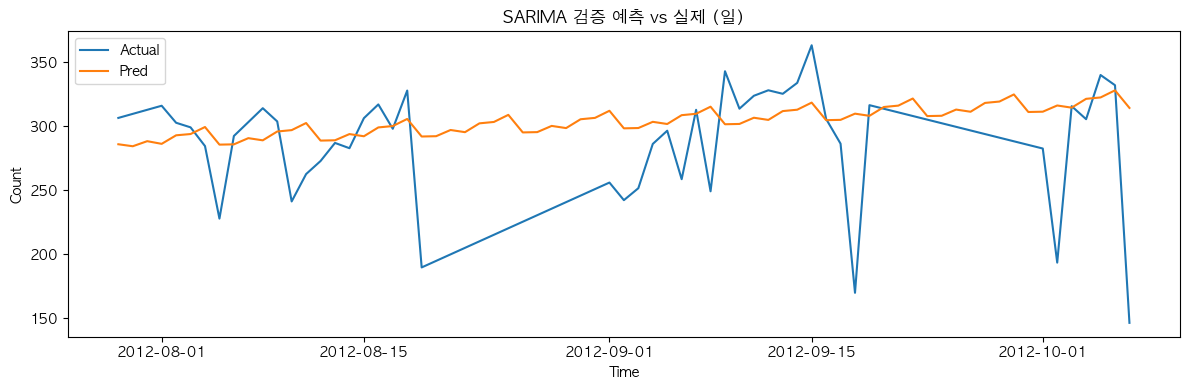

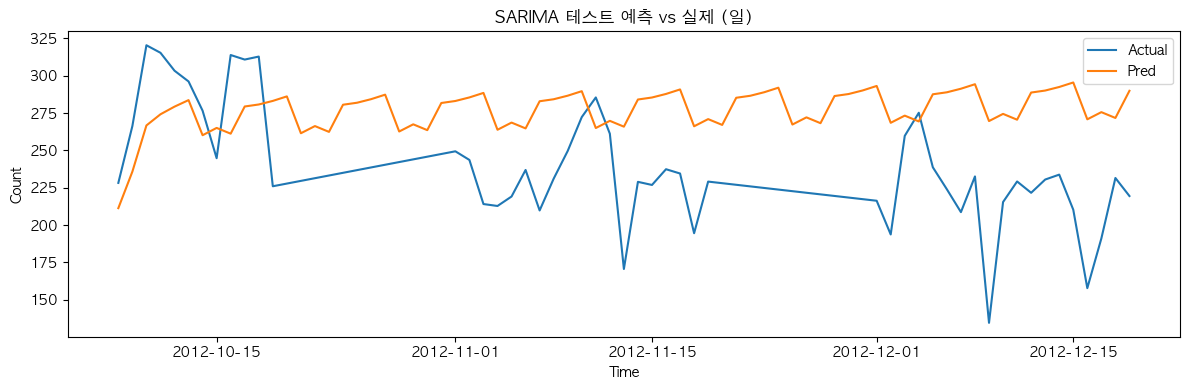

23:35:14 - cmdstanpy - INFO - Chain [1] start processing
23:35:14 - cmdstanpy - INFO - Chain [1] done processing


[Metrics]
MAE  : 55.136594 - ÌèâÍ∑† Ï†àÎåÄ Ïò§Ï∞®
MSE  : 5054.311634 - ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®
RMSE : 71.093682 - Ï†úÍ≥±Í∑º ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®
R^2  : -1.438102 - Í≤∞Ï†ïÍ≥ÑÏàò(ÏÑ§Î™ÖÎêú Î∂ÑÏÇ∞ ÎπÑÏú®)
Prophet/VAL (55.136593561391784, 5054.311634076586, 71.09368209676994, -1.4381020256323187)


In [10]:
def aggregate_daily(df: pd.DataFrame) -> pd.Series:
    return df.set_index('datetime')['count'].resample('D').mean()


daily = aggregate_daily(df)
daily = daily.asfreq('D').interpolate().ffill().bfill()
N = len(daily)
N_tr, N_va = int(N*0.8), int(N*0.1)
daily_tr = daily.iloc[:N_tr]
daily_va = daily.iloc[N_tr:N_tr+N_va]
daily_te = daily.iloc[N_tr+N_va:]

sar = SARIMAX(daily_tr, order=(1,1,1), seasonal_order=(1,1,1,7), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
va_fc = sar.forecast(steps=len(daily_va)).to_numpy()
combined = pd.concat([daily_tr, daily_va])
#te_fc = SARIMAX(daily_tr.append(daily_va), order=(1,1,1), seasonal_order=(1,1,1,7), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False).forecast(steps=len(daily_te)).to_numpy()
te_fc = (
    SARIMAX(combined, order=(1,1,1), seasonal_order=(1,1,1,7),
            enforce_stationarity=False, enforce_invertibility=False)
    .fit(disp=False)
    .forecast(steps=len(daily_te))
    .to_numpy()
)
print('SARIMA/VAL', compute_metrics(daily_va.to_numpy(), va_fc))
print('SARIMA/TEST', compute_metrics(daily_te.to_numpy(), te_fc))
plot_actual_vs_pred(daily_va.index, daily_va.to_numpy(), va_fc, 'SARIMA Í≤ÄÏ¶ù ÏòàÏ∏° vs Ïã§Ï†ú (Ïùº)')
plot_actual_vs_pred(daily_te.index, daily_te.to_numpy(), te_fc, 'SARIMA ÌÖåÏä§Ìä∏ ÏòàÏ∏° vs Ïã§Ï†ú (Ïùº)')

if _HAS_PROPHET:
    dprop = pd.DataFrame({'ds': daily_tr.index, 'y': daily_tr.values})
    m = Prophet(seasonality_mode='additive', weekly_seasonality=True, daily_seasonality=False, yearly_seasonality=False)
    m.fit(dprop)
    future = pd.DataFrame({'ds': pd.date_range(start=daily_tr.index[-1] + pd.Timedelta(days=1), periods=len(daily_va), freq='D')})
    yhat_val = m.predict(future)['yhat'].to_numpy()
    print('Prophet/VAL', compute_metrics(daily_va.to_numpy(), yhat_val))
else:
    print('Prophet ÎØ∏ÏÑ§Ïπò: Í±¥ÎÑàÎúÄ')


In [56]:
def make_windows(X: np.ndarray, y: np.ndarray, window: int, horizon: int = 1):
    xs, ys = [], []
    for i in range(len(X) - window - horizon + 1):
        xs.append(X[i:i+window])
        ys.append(y[i+window:i+window+horizon])
    return np.asarray(xs, dtype=np.float32), np.asarray(ys, dtype=np.float32)


### 3. ÌïôÏäµ/Í≤ÄÏ¶ù/ÌÖåÏä§Ìä∏
- ÌëúÏ§ÄÌôî: train Í∏∞Ï§Ä ÌèâÍ∑†/ÌëúÏ§ÄÌé∏Ï∞®
- ÌïôÏäµ: Adam + MSE, Î≤†Ïä§Ìä∏ Î™®Îç∏ ÏÑ†ÌÉù
- ÏòàÏ∏° vs Ïã§Ï†ú ÏãúÍ∞ÅÌôî


LSTM/VAL (50.116783142089844, 5978.74169921875, 77.32232342098077, 26.463699340820312, 0.8608695652173913)
LSTM/TEST (46.46815872192383, 4709.2314453125, 68.62384021105566, 29.130691289901733, 0.8026030368763557)


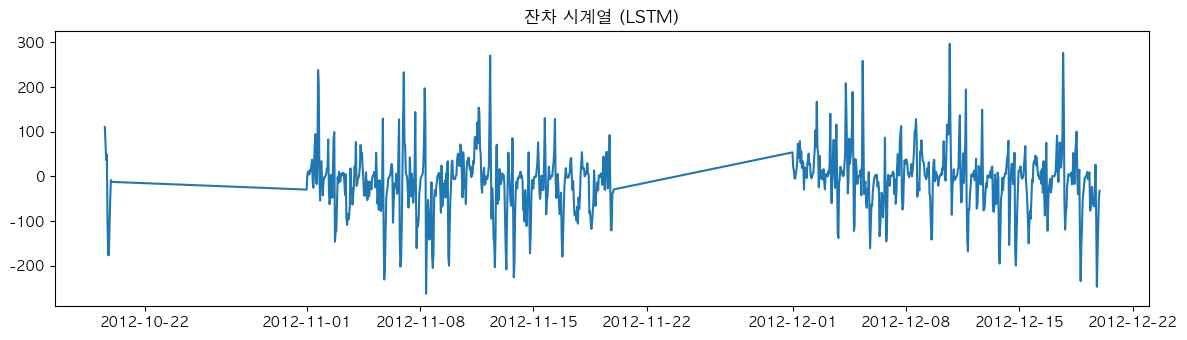

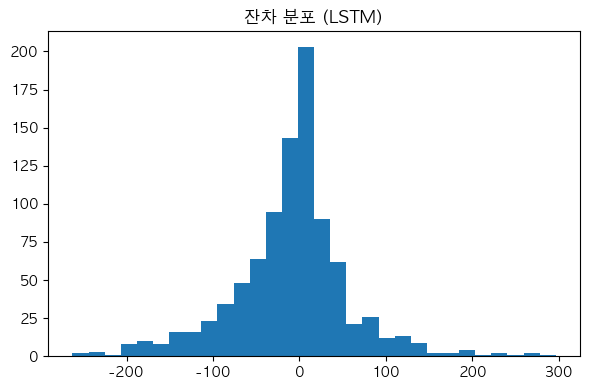

In [ ]:
def compute_metrics(y_true, y_pred):
    mae = float(np.mean(np.abs(y_true - y_pred)))
    mse = float(np.mean((y_true - y_pred)**2))
    rmse = float(np.sqrt(mse))
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = float(np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100.0)
    prev = np.concatenate([[y_true[0]], y_true[:-1]])
    da = float(np.mean((np.sign(y_true - prev) == np.sign(y_pred - prev)).astype(float)))
    return mae, mse, rmse, mape, da

# Î°úÍ∑∏ ÌÉÄÍπÉ Î≥µÏõê ÌõÑ ÌèâÍ∞Ä
if 'use_log_target' in globals() and use_log_target:
    yva_true = np.expm1(yva_seq.squeeze(-1))
    yte_true = np.expm1(yte_seq.squeeze(-1))
    val_pred_eval = np.expm1(val_pred)
    test_pred_eval = np.expm1(test_pred)
else:
    yva_true = yva_seq.squeeze(-1)
    yte_true = yte_seq.squeeze(-1)
    val_pred_eval = val_pred
    test_pred_eval = test_pred

print('LSTM/VAL', compute_metrics(yva_true, val_pred_eval))
print('LSTM/TEST', compute_metrics(yte_true, test_pred_eval))

# ÏûîÏ∞® Î∂ÑÏÑù(Î≥µÏõêÎêú Ïä§ÏºÄÏùº Í∏∞Ï§Ä)
residual = yte_true - test_pred_eval
plt.figure(figsize=(12,3.5))
plt.plot(test_idx, residual)
plt.title('ÏûîÏ∞® ÏãúÍ≥ÑÏó¥ (LSTM)')
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.hist(residual, bins=30)
plt.title('ÏûîÏ∞® Î∂ÑÌè¨ (LSTM)')
plt.tight_layout(); plt.show()


In [ ]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Ï§ÄÎπÑ: ÏúàÎèÑÏö∞ Îç∞Ïù¥ÌÑ∞(X*_seq, y*_seq)ÏôÄ ÌëúÏ§ÄÌôî ÌÜµÍ≥Ñ(mean, std)Îäî Í∏∞Ï°¥ ÏÖÄÏóêÏÑú ÏÉùÏÑ±Îê®
# Xtr_seq:[N,T,F], ytr_seq:[N] (ÎòêÎäî [N,1]) Í∞ÄÏ†ï

def to_tensor(x):
    return torch.tensor(x, dtype=torch.float32)

# ÎîîÎ∞îÏù¥Ïä§ ÏÑ†ÌÉù(MPS ÎπÑÌôúÏÑ± Ïãú CPU)
_device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# ÌÖêÏÑú Î≥ÄÌôò Î∞è Îç∞Ïù¥ÌÑ∞Î°úÎçî Íµ¨ÏÑ±
_Xtr = to_tensor(Xtr_seq).to(_device)
_ytr = to_tensor(ytr_seq.squeeze(-1) if ytr_seq.ndim > 1 else ytr_seq).to(_device)
_Xva = to_tensor(Xva_seq).to(_device)
_yva = to_tensor(yva_seq.squeeze(-1) if yva_seq.ndim > 1 else yva_seq).to(_device)
_Xte = to_tensor(Xte_seq).to(_device)
_yte = to_tensor(yte_seq.squeeze(-1) if yte_seq.ndim > 1 else yte_seq).to(_device)

train_ds2 = TensorDataset(_Xtr, _ytr)
val_ds2   = TensorDataset(_Xva, _yva)
test_ds2  = TensorDataset(_Xte, _yte)

train_dl2 = DataLoader(train_ds2, batch_size=128, shuffle=False, drop_last=True)
val_dl2   = DataLoader(val_ds2,   batch_size=256, shuffle=False)
test_dl2  = DataLoader(test_ds2,  batch_size=256, shuffle=False)

# Î™®Îç∏ Ïù∏Ïä§ÌÑ¥Ïä§(ÌÅ¥ÎûòÏä§ Ï†ïÏùò ÏóÜÏù¥)
input_size = _Xtr.shape[-1]
hidden_size = 64
num_layers = 1

lstm2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True).to(_device)
head2 = nn.Linear(hidden_size, 1).to(_device)

params2 = list(lstm2.parameters()) + list(head2.parameters())
optim2 = torch.optim.Adam(params2, lr=1e-3)
crit2 = nn.MSELoss()

# ÏàúÏ†ÑÌåå Ìï®Ïàò

def forward_step2(x_batch: torch.Tensor) -> torch.Tensor:
    out, _ = lstm2(x_batch)
    last = out[:, -1, :]
    pred = head2(last).squeeze(-1)
    return pred

# ÌïôÏäµ Î£®ÌîÑ

def train_epoch2(loader: DataLoader) -> float:
    lstm2.train(); head2.train()
    total, n = 0.0, 0
    for xb, yb in loader:
        optim2.zero_grad(set_to_none=True)
        pred = forward_step2(xb)
        loss = crit2(pred, yb)
        loss.backward()
        optim2.step()
        total += float(loss.item()) * yb.size(0)
        n += yb.size(0)
    return total / max(n, 1)

@torch.no_grad()
def eval_mse2(loader: DataLoader) -> float:
    lstm2.eval(); head2.eval()
    total, n = 0.0, 0
    for xb, yb in loader:
        pred = forward_step2(xb)
        loss = crit2(pred, yb)
        total += float(loss.item()) * yb.size(0)
        n += yb.size(0)
    return total / max(n, 1)

best_state2 = None
best_val2 = float('inf')
for ep in range(1, 11):
    tr = train_epoch2(train_dl2)
    va = eval_mse2(val_dl2)
    print(f'[NoClass] Epoch {ep:02d} | train MSE {tr:.4f} | val MSE {va:.4f}')
    if va < best_val2:
        best_val2 = va
        best_state2 = {
            'lstm': {k: v.detach().cpu().clone() for k, v in lstm2.state_dict().items()},
            'head': {k: v.detach().cpu().clone() for k, v in head2.state_dict().items()},
        }

# Î≤†Ïä§Ìä∏ Î°úÎìú
if best_state2 is not None:
    lstm2.load_state_dict(best_state2['lstm'])
    head2.load_state_dict(best_state2['head'])

# ÏòàÏ∏°
@torch.no_grad()
def predict_all2(loader: DataLoader) -> np.ndarray:
    lstm2.eval(); head2.eval()
    outs = []
    for xb, _ in loader:
        pred = forward_step2(xb)
        outs.append(pred.cpu().numpy())
    return np.concatenate(outs, axis=0)

val_pred2 = predict_all2(val_dl2)
test_pred2 = predict_all2(test_dl2)

# Í∞ÑÎã®Ìïú ÏÑ±Îä• ÌôïÏù∏
from math import sqrt
mae2 = float(np.mean(np.abs((_yva.cpu().numpy()) - val_pred2)))
rmse2 = sqrt(float(np.mean(((_yva.cpu().numpy()) - val_pred2)**2)))
print('[NoClass] VAL MAE/RMSE:', round(mae2, 3), round(rmse2, 3))



[NoClass] Epoch 01 | train MSE 11.9627 | val MSE 1.7784
[NoClass] Epoch 02 | train MSE 1.9208 | val MSE 1.3761
[NoClass] Epoch 03 | train MSE 1.2818 | val MSE 0.8820
[NoClass] Epoch 04 | train MSE 0.8346 | val MSE 0.5418
[NoClass] Epoch 05 | train MSE 0.5948 | val MSE 0.4155
[NoClass] Epoch 06 | train MSE 0.4813 | val MSE 0.3263
[NoClass] Epoch 07 | train MSE 0.4157 | val MSE 0.2868
[NoClass] Epoch 08 | train MSE 0.3780 | val MSE 0.2633
[NoClass] Epoch 09 | train MSE 0.3559 | val MSE 0.2477
[NoClass] Epoch 10 | train MSE 0.3455 | val MSE 0.2356
[NoClass] VAL MAE/RMSE: 0.38 0.485


## Classical Baselines  {#classical-baselines}

## Chapter 2-3, 2-1Í∞ï ÏãúÍ≥ÑÏó¥ ÏòàÏ∏° Î™®Îç∏ÎßÅ ‚Äî Classical & Baselines (Bike Sharing)

- **Î™©Ìëú**: ÌöåÍ∑Ä(ÏÑ†Ìòï/ÎûúÎç§Ìè¨Î†àÏä§Ìä∏), ÏãúÍ≥ÑÏó¥ Ï†ÑÏö©(SARIMA/Prophet) Î™®Îç∏ÏùÑ Îã®Í≥ÑÎ≥ÑÎ°ú ÌïôÏäµ¬∑ÌèâÍ∞ÄÌïòÏó¨ ÎπÑÍµêÌï©ÎãàÎã§.
- **Îç∞Ïù¥ÌÑ∞**: Kaggle Bike Sharing Demand (ÏãúÍ∞Ñ Îã®ÏúÑ, `count` ÎåÄÏÉÅ)
- **Í∑úÏπô(Í∞ïÏùòÏö©)**: `matplotlib`Îßå ÏÇ¨Ïö© (seaborn X), ÏÉâÏÉÅ ÏßÄÏ†ï X, ÏÑúÎ∏åÌîåÎ°Ø X


### 0. ÌôòÍ≤Ω Ï§ÄÎπÑ Î∞è ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏

- ÏãúÍ∞ÅÌôîÎäî `matplotlib`Îßå ÏÇ¨Ïö©Ìï©ÎãàÎã§.
- ÌöåÍ∑Ä Î™®Îç∏(`scikit-learn`), ÏãúÍ≥ÑÏó¥(`statsmodels`), Prophet(ÏÑ†ÌÉù)ÏùÑ ÏÇ¨Ïö©Ìï©ÎãàÎã§.
- ÌïúÍ∏Ä Ìè∞Ìä∏ÏôÄ Í≤ΩÍ≥† ÏñµÏ†úÎ•º ÏÑ§Ï†ïÌï©ÎãàÎã§.


### 3. ÏãúÍ≥ÑÏó¥ Ï†ÑÏö© Î™®Îç∏: SARIMA, Prophet(ÏÑ†ÌÉù)
- Ïùº Îã®ÏúÑ ÌèâÍ∑†ÏúºÎ°ú ÏßëÍ≥Ñ ÌõÑ ÏòàÏ∏°
- SARIMA Í∏∞Î≥∏ ÌååÎùºÎØ∏ÌÑ∞Î°ú ÏãúÏó∞, ProphetÏùÄ ÏÑ§Ïπò Ïãú Ïã§Ìñâ


## Ïôú SARIMAÏôÄ ProphetÏùÄ ÏÑ±Îä•Ïù¥ ÎÇÆÏùÑÍπå?

### 1. Îç∞Ïù¥ÌÑ∞ ÌäπÏÑ±Í≥ºÏùò Î∂ÄÏ†ÅÌï©ÏÑ±
- SARIMA/ProphetÏùÄ **Ï∂îÏÑ∏ + Í≥ÑÏ†àÏÑ±** Ìå®ÌÑ¥Ïù¥ ÎöúÎ†∑ÌïòÍ≥† ÎπÑÍµêÏ†Å ÏïàÏ†ïÏ†ÅÏù∏ ÏãúÍ≥ÑÏó¥ Îç∞Ïù¥ÌÑ∞Ïóê Í∞ïÏ†êÏù¥ ÏûàÏùå.  
- ÌïòÏßÄÎßå ÏûêÏ†ÑÍ±∞ ÎåÄÏó¨ Îç∞Ïù¥ÌÑ∞Îäî Îã§ÏùåÍ≥º Í∞ôÏùÄ ÌäπÏÑ±Ïù¥ Ï°¥Ïû¨:
  - **Ïô∏Î∂Ä ÏöîÏù∏**(Í∏∞Ïò®, ÏäµÎèÑ, ÎÇ†Ïî®, ÏöîÏùº, Í∑ºÎ¨¥Ïùº Ïó¨Î∂Ä, ÏãúÍ∞ÑÎåÄ Îì±)Ïóê ÌÅ¨Í≤å ÏùòÏ°¥  
  - ÎÇ†Ïî® Î≥ÄÌôîÎÇò Ìú¥Ïùº Ïù¥Î≤§Ìä∏ Îì±ÏúºÎ°ú **Í∏âÍ≤©Ìïú ÏàòÏöî Î≥ÄÎèô(Ïä§ÌååÏù¥ÌÅ¨)** Î∞úÏÉù  
- Îî∞ÎùºÏÑú Îã®ÏàúÌûà Í≥ºÍ±∞ ÏãúÍ≥ÑÏó¥ Ìå®ÌÑ¥Îßå Î≥¥Îäî SARIMA/ProphetÏùÄ Ïù¥Î•º Ï†úÎåÄÎ°ú Î∞òÏòÅÌïòÏßÄ Î™ªÌï®.  

---

### 2. Î™®Îç∏Ïùò Íµ¨Ï°∞Ï†Å ÌïúÍ≥Ñ
#### SARIMA
- ÏûêÍ∏∞ÌöåÍ∑Ä(AR) + Ï∞®Î∂Ñ(I) + Ïù¥ÎèôÌèâÍ∑†(MA) + Í≥ÑÏ†àÏÑ±(S)ÏùÑ Í∏∞Î∞òÏúºÎ°ú ÏûëÎèô.  
- **Îã®Ïùº/Í≥†Ï†ïÎêú Í≥ÑÏ†àÏÑ±**ÏóêÎäî Ïûò ÎßûÏßÄÎßå, ÏûêÏ†ÑÍ±∞ ÎåÄÏó¨ Îç∞Ïù¥ÌÑ∞Ï≤òÎüº **ÌïòÎ£® Ï£ºÍ∏∞ + Ï£ºÍ∞Ñ Ï£ºÍ∏∞ + ÎÇ†Ïî® ÏòÅÌñ•**Ïù¥ ÎèôÏãúÏóê Ï°¥Ïû¨ÌïòÎäî Í≤ΩÏö∞ ÌïúÍ≥ÑÍ∞Ä ÏûàÏùå.  
- ÌäπÌûà ÏãúÍ∞ÑÎåÄÎ≥Ñ Î≥ÄÎèôÏÑ±Ïù¥ ÌÅ∞ Ìå®ÌÑ¥ÏùÑ Ìè¨Ï∞©ÌïòÍ∏∞ Ïñ¥Î†§ÏõÄ.  

#### Prophet
- Íµ¨Ï°∞: **Ìä∏Î†åÎìú + Ï£ºÍ∞Ñ/Ïó∞Í∞Ñ Í≥ÑÏ†àÏÑ± + Ìú¥Ïùº Ìö®Í≥º**  
- Ïû•Ï†ê: Ìú¥Ïùº Ìö®Í≥º Î∞òÏòÅ, ÎπÑÏÑ†Ìòï Ìä∏Î†åÎìú Ï≤òÎ¶¨  
- Îã®Ï†ê: **Îã®Í∏∞ Î≥ÄÎèôÏÑ±**Í≥º **ÎπÑÏÑ†Ìòï Ïô∏Î∂Ä Î≥ÄÏàò Ìö®Í≥º**(Ïòà: ÌäπÏ†ï Í∏∞Ïò® Íµ¨Í∞ÑÏóêÏÑú ÏàòÏöî Í∏âÏ¶ù)Î•º Î∞òÏòÅÌïòÍ∏∞ Ïñ¥Î†§ÏõÄ.  
- Ïù¥Î≤à Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ï§ëÏöîÌïú Í∏∞ÏÉÅ¬∑ÏãúÍ∞Ñ ÏöîÏù∏ÏùÑ ÏßÅÏ†ë Î∞òÏòÅÌï† Ïàò ÏóÜÏóàÏùå.  

---

### 3. Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨/Î∂ÑÌï¥ ÌïúÍ≥Ñ
- Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞ÏóêÎäî Í≤∞Ï∏°Ïπò, Ïù¥ÏÉÅÏπò, Í∑πÎã®Ï†Å Ïù¥Î≤§Ìä∏(Ìè≠Ïö∞, Ìè≠ÏÑ§ Îì±)Í∞Ä Ìè¨Ìï®ÎêòÏñ¥ ÏûàÏùå.  
- SARIMA/ProphetÏùÄ Ïù¥Îü∞ Ïù¥ÏÉÅ Î≥ÄÎèôÏùÑ **Ï∂îÏÑ∏/Í≥ÑÏ†àÏÑ±ÏúºÎ°ú ÏûòÎ™ª Ìù°Ïàò**ÌïòÏó¨ Ïò§Ï∞®Í∞Ä Ïª§Ïßê.  

---

### 4. Îã§Î•∏ Î™®Îç∏Í≥ºÏùò ÎπÑÍµê
- **Linear Regression, RandomForest** Îì± Î®∏Ïã†Îü¨Îãù Î™®Îç∏ÏùÄ **Ïô∏Î∂Ä ÌîºÏ≤ò**Î•º ÏßÅÏ†ë ÌôúÏö© Í∞ÄÎä•:
  - Í∏∞Ïò®Ïù¥ ÎÜíÏùÑ Îïå ÏàòÏöî Ï¶ùÍ∞Ä  
  - Ìá¥Í∑º ÏãúÍ∞ÑÎåÄ(17~19Ïãú) ÏàòÏöî Ìè≠Ï¶ù  
- Îî∞ÎùºÏÑú ÎπÑÏÑ†Ìòï¬∑Î≥µÌï©Ï†ÅÏù∏ ÏöîÏù∏ÏùÑ ÌïôÏäµÌïòÏó¨ ÏÑ±Îä•Ïù¥ Ìñ•ÏÉÅÎê®.  
- Î∞òÎ©¥ SARIMA/ProphetÏùÄ **Ïô∏Î∂Ä ÏöîÏù∏ ÏóÜÏù¥ Ïò§ÏßÅ Í≥ºÍ±∞ ÏàòÏöî Îç∞Ïù¥ÌÑ∞Îßå** ÏÇ¨Ïö© ‚Üí ÏÑ±Îä•Ïù¥ ÎÇÆÍ≤å ÎÇòÌÉÄÎÇ®.  

---

## üîé Í≤∞Î°†
- SARIMA/ProphetÏùò ÎÇÆÏùÄ ÏÑ±Îä• Ïù¥Ïú†:
  1. **Ïô∏Î∂Ä ÏöîÏù∏(ÎÇ†Ïî®¬∑ÏöîÏùº¬∑ÏãúÍ∞ÑÎåÄ)ÏùÑ Î∞òÏòÅÌïòÏßÄ Î™ªÌï®**  
  2. **Í∏âÍ≤©Ìïú ÏàòÏöî Î≥ÄÎèô(Ïä§ÌååÏù¥ÌÅ¨)Ïóê Ï∑®ÏïΩ**  
  3. **Îã§Ï§ë Í≥ÑÏ†àÏÑ±Í≥º ÎπÑÏÑ†Ìòï Íµ¨Ï°∞Î•º Ï∂©Î∂ÑÌûà ÏÑ§Î™ÖÌïòÏßÄ Î™ªÌï®**  

üëâ Ïù¥ Îç∞Ïù¥ÌÑ∞ÏóêÏÑúÎäî **ÎûúÎç§Ìè¨Î†àÏä§Ìä∏ Í∞ôÏùÄ ÌîºÏ≤ò Í∏∞Î∞ò Î®∏Ïã†Îü¨Îãù Î™®Îç∏**Ïù¥ Ìõ®Ïî¨ Îçî Ï†ÅÌï©ÌïòÎ©∞,  
Ï∂îÍ∞ÄÎ°ú Gradient Boosting Í≥ÑÏó¥(XGBoost, LightGBM)Ïù¥ÎÇò ÏãúÍ≥ÑÏó¥ ÌäπÌôî Îî•Îü¨Îãù(LSTM Îì±)ÏùÑ Í≥†Î†§Ìï† Ïàò ÏûàÏùå.


## LSTM Modeling  {#lstm-modeling}

In [57]:
# ÌÅ¥ÎûòÏä§ ÏóÜÏù¥ ÏÇ¨Ïö©Ìï† LSTM Ìó¨Ìçº Ï†ïÏùò

def make_lstm_pair(input_size: int, hidden_size: int = 64, num_layers: int = 2, dropout: float = 0.1, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    lstm = nn.LSTM(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_first=True,
        dropout=dropout,
    ).to(device)
    head = nn.Linear(hidden_size, 1).to(device)
    return lstm, head, device


def lstm_forward(lstm: nn.LSTM, head: nn.Linear, x: torch.Tensor) -> torch.Tensor:
    out, _ = lstm(x)
    last = out[:, -1, :]
    return head(last).squeeze(-1)



### 3-1. ÌÅ¥ÎûòÏä§ ÏóÜÏù¥ Íµ¨ÌòÑÌïú LSTM ÌïôÏäµ Î£®ÌîÑ(ÎåÄÏïà)
- ÏÇ¨Ïö©Ïûê Ï†ïÏùò `nn.Module` ÌÅ¥ÎûòÏä§Î•º ÎßåÎì§ÏßÄ ÏïäÍ≥†, `nn.LSTM`Í≥º `nn.Linear` Ïù∏Ïä§ÌÑ¥Ïä§Î•º ÏßÅÏ†ë ÏÇ¨Ïö©
- Îç∞Ïù¥ÌÑ∞ÏÖãÎèÑ `TensorDataset`ÏúºÎ°ú Í∞ÑÎã®Ìûà Íµ¨ÏÑ±
- Í∏∞Ï°¥ ÏΩîÎìúÏôÄ Í≥µÏ°¥ÌïòÎ©∞, ÎπÑÍµê/Ï∞∏Í≥†Ïö©ÏúºÎ°ú Ïã§Ìñâ Í∞ÄÎä•


## Training & Evaluation  {#training-evaluation}

### 2. ÏùºÎ∞ò ÌöåÍ∑Ä Î≤†Ïù¥Ïä§ÎùºÏù∏: ÏÑ†Ìòï ÌöåÍ∑Ä vs ÎûúÎç§Ìè¨Î†àÏä§Ìä∏
- ÏûÖÎ†•: ÏãúÍ∞Ñ ÌååÏÉù + Í∏∞ÏÉÅ/ÏÉÅÌÉú Î≥ÄÏàò, ÌÉÄÍπÉ: `count`
- ÌèâÍ∞Ä: MAE/MSE/RMSE/MAPE, Î∞©Ìñ•Ï†ïÌôïÎèÑ(DA)


[Metrics]
MAE  : 59.311357 - ÌèâÍ∑† Ï†àÎåÄ Ïò§Ï∞®
MSE  : 8326.449294 - ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®
RMSE : 91.249380 - Ï†úÍ≥±Í∑º ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®
R^2  : 0.850787 - Í≤∞Ï†ïÍ≥ÑÏàò(ÏÑ§Î™ÖÎêú Î∂ÑÏÇ∞ ÎπÑÏú®)
[Metrics]
MAE  : 60.226095 - ÌèâÍ∑† Ï†àÎåÄ Ïò§Ï∞®
MSE  : 8501.793626 - ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®
RMSE : 92.205171 - Ï†úÍ≥±Í∑º ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®
R^2  : 0.847645 - Í≤∞Ï†ïÍ≥ÑÏàò(ÏÑ§Î™ÖÎêú Î∂ÑÏÇ∞ ÎπÑÏú®)
[Metrics]
MAE  : 61.818753 - ÌèâÍ∑† Ï†àÎåÄ Ïò§Ï∞®
MSE  : 8729.076045 - ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®
RMSE : 93.429524 - Ï†úÍ≥±Í∑º ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®
R^2  : 0.843572 - Í≤∞Ï†ïÍ≥ÑÏàò(ÏÑ§Î™ÖÎêú Î∂ÑÏÇ∞ ÎπÑÏú®)
[Metrics]
MAE  : 63.734434 - ÌèâÍ∑† Ï†àÎåÄ Ïò§Ï∞®
MSE  : 9008.296552 - ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®
RMSE : 94.912046 - Ï†úÍ≥±Í∑º ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®
R^2  : 0.838568 - Í≤∞Ï†ïÍ≥ÑÏàò(ÏÑ§Î™ÖÎêú Î∂ÑÏÇ∞ ÎπÑÏú®)
[Metrics]
MAE  : 65.902910 - ÌèâÍ∑† Ï†àÎåÄ Ïò§Ï∞®
MSE  : 9339.455145 - ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®
RMSE : 96.640856 - Ï†úÍ≥±Í∑º ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®
R^2  : 0.832634 - Í≤∞Ï†ïÍ≥ÑÏàò(ÏÑ§Î™ÖÎêú Î∂ÑÏÇ∞ ÎπÑÏú®)
[Metrics]


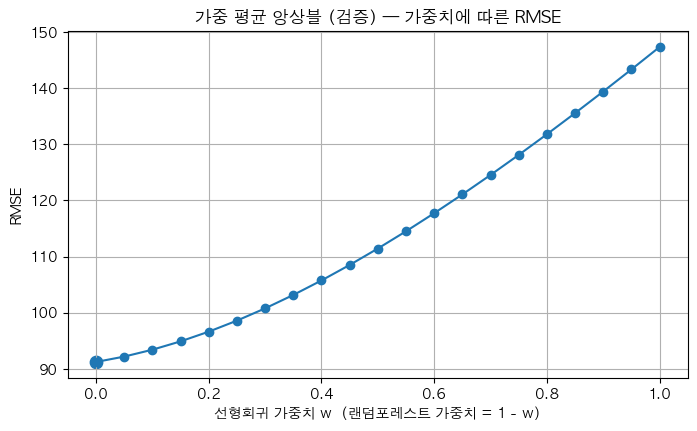


[Í≤ÄÏ¶ù Í≤∞Í≥º ÏÉÅÏúÑ 5Í∞ú (RMSE Í∏∞Ï§Ä)]
 w(linear)  w(rf)  linear%  rf%    MAE   RMSE    R2
     0.000  1.000        0  100 59.311 91.249 0.851
     0.050  0.950        5   95 60.226 92.205 0.848
     0.100  0.900       10   90 61.819 93.430 0.844
     0.150  0.850       15   85 63.734 94.912 0.839
     0.200  0.800       20   80 65.903 96.641 0.833
[Metrics]
MAE  : 68.762976 - ÌèâÍ∑† Ï†àÎåÄ Ïò§Ï∞®
MSE  : 10117.330518 - ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®
RMSE : 100.584942 - Ï†úÍ≥±Í∑º ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®
R^2  : 0.731398 - Í≤∞Ï†ïÍ≥ÑÏàò(ÏÑ§Î™ÖÎêú Î∂ÑÏÇ∞ ÎπÑÏú®)

[ÏöîÏïΩ]
- ÏµúÏ†Å Í∞ÄÏ§ëÏπò w = 0.00  (ÏÑ†ÌòïÌöåÍ∑Ä 0%, ÎûúÎç§Ìè¨Î†àÏä§Ìä∏ 100%)
- Í≤ÄÏ¶ù RMSE = 91.249
- ÌÖåÏä§Ìä∏ ÏÑ±Îä• ‚Üí MAE=68.763, RMSE=100.585, R^2=0.731


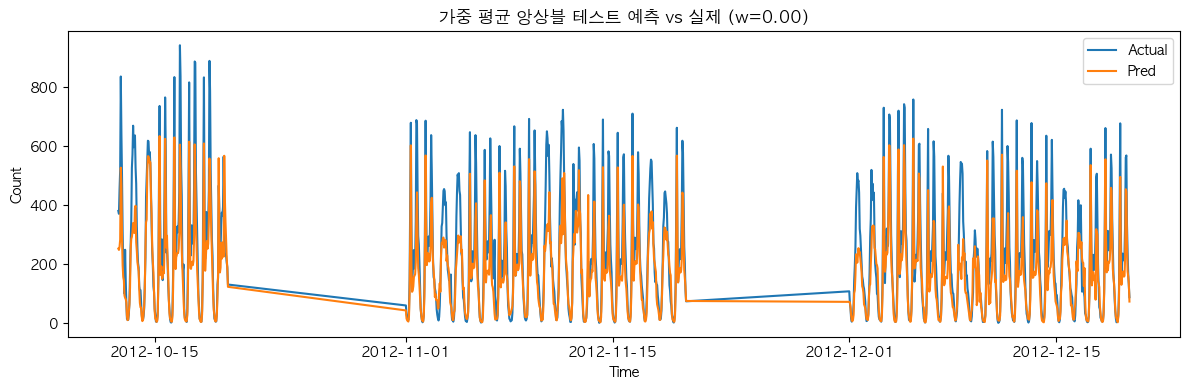

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def weighted_ensemble(y1, y2, w):
    return w*y1 + (1-w)*y2

# Í∞ÄÏ§ëÏπò ÌÉêÏÉâ + Í≤∞Í≥º ÏöîÏïΩ/ÏãúÍ∞ÅÌôî
def search_weight_and_report(lin_val_pred, rf_val_pred, y_val,
                             lin_test_pred, rf_test_pred, y_test,
                             weights=np.linspace(0, 1, 21),
                             title_prefix='ÏïôÏÉÅÎ∏î'):
    rows = []
    best_w, best_rmse = None, float('inf')

    # 1) Í≤ÄÏ¶ùÏóêÏÑú Í∞ÄÏ§ëÏπòÎ≥Ñ ÏÑ±Îä• Ï∏°Ï†ï
    for w in weights:
        ens_val = weighted_ensemble(lin_val_pred, rf_val_pred, w)
        mae, mse, rmse, r2 = compute_metrics(y_val.to_numpy(), ens_val)
        rows.append({
            'weight_linear': float(w),
            'weight_rf': float(1-w),
            'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2
        })
        if rmse < best_rmse:
            best_rmse = rmse
            best_w = w

    # 2) ÌëúÎ°ú Ï†ïÎ¶¨
    df = pd.DataFrame(rows)
    df_sorted = df.sort_values('weight_linear').reset_index(drop=True)

    # 3) Í∞ÄÏ§ëÏπò-ÏÑ±Îä• Í≥°ÏÑ† ÏãúÍ∞ÅÌôî (RMSE Í∏∞Ï§Ä)
    plt.figure(figsize=(8,4.5))
    plt.plot(df_sorted['weight_linear'], df_sorted['RMSE'], marker='o')
    # ÏµúÏ†ÅÏ†ê Í∞ïÏ°∞
    plt.scatter([best_w], [best_rmse], s=80)
    plt.title(f'{title_prefix} (Í≤ÄÏ¶ù) ‚Äî Í∞ÄÏ§ëÏπòÏóê Îî∞Î•∏ RMSE')
    plt.xlabel('ÏÑ†ÌòïÌöåÍ∑Ä Í∞ÄÏ§ëÏπò w  (ÎûúÎç§Ìè¨Î†àÏä§Ìä∏ Í∞ÄÏ§ëÏπò = 1 - w)')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.show()

    # 4) ÏÉÅÏúÑ 5Í∞ú(ÎÇÆÏùÄ RMSE) Ï∂úÎ†•
    topk = df.nsmallest(5, 'RMSE').copy()
    topk['linear%'] = (topk['weight_linear']*100).round(0).astype(int)
    topk['rf%'] = (topk['weight_rf']*100).round(0).astype(int)
    print('\n[Í≤ÄÏ¶ù Í≤∞Í≥º ÏÉÅÏúÑ 5Í∞ú (RMSE Í∏∞Ï§Ä)]')
    print(topk[['weight_linear', 'weight_rf', 'linear%', 'rf%', 'MAE', 'RMSE', 'R2']]
          .rename(columns={
              'weight_linear':'w(linear)',
              'weight_rf':'w(rf)'
          }).to_string(index=False, float_format=lambda x: f'{x:,.3f}'))

    # 5) ÏµúÏ†Å Í∞ÄÏ§ëÏπòÎ°ú ÌÖåÏä§Ìä∏ ÏÑ±Îä• ÌèâÍ∞Ä
    ens_test = weighted_ensemble(lin_test_pred, rf_test_pred, best_w)
    mae_t, mse_t, rmse_t, r2_t = compute_metrics(y_test.to_numpy(), ens_test)

    print('\n[ÏöîÏïΩ]')
    print(f"- ÏµúÏ†Å Í∞ÄÏ§ëÏπò w = {best_w:.2f}  "
          f"(ÏÑ†ÌòïÌöåÍ∑Ä {best_w*100:.0f}%, ÎûúÎç§Ìè¨Î†àÏä§Ìä∏ {(1-best_w)*100:.0f}%)")
    print(f"- Í≤ÄÏ¶ù RMSE = {best_rmse:.3f}")
    print(f"- ÌÖåÏä§Ìä∏ ÏÑ±Îä• ‚Üí MAE={mae_t:.3f}, RMSE={rmse_t:.3f}, R^2={r2_t:.3f}")

    # 6) ÌÖåÏä§Ìä∏ Íµ¨Í∞Ñ Ïã§Ï†ú vs ÏòàÏ∏° Í∑∏ÎûòÌîÑ (Í∏∞Ï°¥ Ìï®Ïàò ÌôúÏö©)
    try:
        plot_actual_vs_pred(
            test_df['datetime'].values,  # Í∏∞Ï°¥Ïóê Ïì∞ÏãúÎçò test_df / xÏ∂ï
            y_test.to_numpy(),
            ens_test,
            f'{title_prefix} ÌÖåÏä§Ìä∏ ÏòàÏ∏° vs Ïã§Ï†ú (w={best_w:.2f})'
        )
    except NameError:
        # ÏÇ¨Ïö© ÌôòÍ≤ΩÏóê Îî∞Îùº test_dfÍ∞Ä ÏóÜÏùÑ Ïàò ÏûàÏúºÎãà ÏïàÏ†ÑÏû•Ïπò
        pass

    return best_w, df_sorted

# ---------------------------
# ÏÇ¨Ïö© ÏòàÏãú (ÌòÑÏû¨ Î≥ÄÏàò Í∑∏ÎåÄÎ°ú ÌôúÏö©)
# ---------------------------
best_w, df_weights = search_weight_and_report(
    lin_val_pred, rf_val_pred, y_val,
    lin_test_pred, rf_test_pred, y_test,
    weights=np.linspace(0, 1, 21),  # 0.00 ~ 1.00, 0.05 Í∞ÑÍ≤©Ïù¥Î©¥  np.linspace(0,1,21)
    title_prefix='Í∞ÄÏ§ë ÌèâÍ∑† ÏïôÏÉÅÎ∏î'
)


### 4. ÏÑ±Îä• ÎπÑÍµê ÏöîÏïΩ
- MAE, MSE, RMSE, MAPE, Î∞©Ìñ•Ï†ïÌôïÎèÑ(DA) ÏßÄÌëú ÎπÑÍµê
- Î™®Îç∏Î≥Ñ ÏòàÏ∏° vs Ïã§Ï†ú ÏãúÍ∞ÅÌôîÎ°ú Ìå®ÌÑ¥ ÎπÑÍµê


### 4. ÏÑ±Îä• ÌèâÍ∞Ä Î∞è ÏûîÏ∞® Î∂ÑÏÑù
- MAE/MSE/RMSE/MAPE, Î∞©Ìñ•Ï†ïÌôïÎèÑ(DA)
- ÏòàÏ∏° vs Ïã§Ï†ú ÌîåÎ°Ø, ÏûîÏ∞® ÏãúÍ∞ÅÌôî


## Residual Analysis  {#residual-analysis}

### 7. ÏûîÏ∞® Î∂ÑÏÑù
- ÌÖåÏä§Ìä∏ Íµ¨Í∞Ñ ÏûîÏ∞® ÏãúÍ∞ÅÌôî Î∞è Î∂ÑÌè¨ ÌôïÏù∏
- Ìå®ÌÑ¥/Ïù¥Î∂ÑÏÇ∞/ÎπÑÏ†ïÏÉÅÏÑ± Ïó¨Î∂Ä Ï†êÍ≤Ä


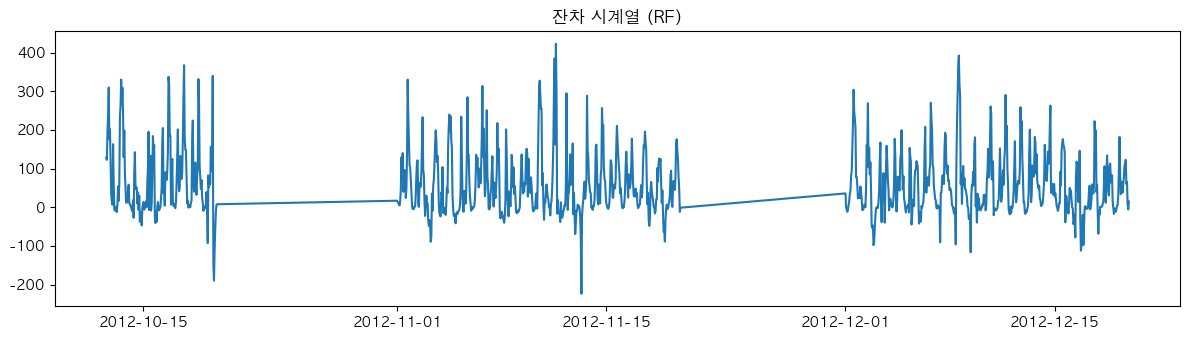

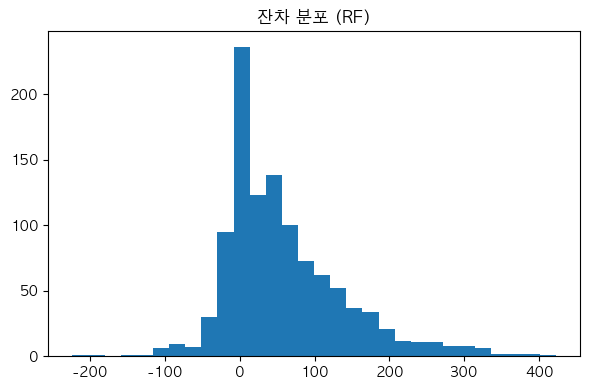

In [9]:
residual = y_test.to_numpy() - rf_test_pred
plt.figure(figsize=(12,3.5))
plt.plot(test_df['datetime'].values, residual)
plt.title('ÏûîÏ∞® ÏãúÍ≥ÑÏó¥ (RF)')
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.hist(residual, bins=30)
plt.title('ÏûîÏ∞® Î∂ÑÌè¨ (RF)')
plt.tight_layout(); plt.show()


## Miscellaneous

# Combined: Classical baselines + LSTM (cleaned)

- Source A: `Classical_baselines_reviewed.ipynb`
- Source B: `LSTM_reviewed.ipynb`
- Merged on: 2025-08-27 20:32:04

Ï§ëÎ≥µÎêòÎäî ÏΩîÎìú/Ï£ºÏÑùÏùÑ Ï†úÍ±∞ÌïòÍ≥†, Í≥µÌÜµ Ïú†Ìã∏Î¶¨Ìã∞Îäî ÌïòÎÇòÎ°ú Ïú†ÏßÄÌñàÏäµÎãàÎã§.

#### Í∞ïÏùò Í∞úÏöî Î∞è ÌïôÏäµ Î™©Ìëú
- ÏãúÍ≥ÑÏó¥ ÏòàÏ∏°Ïùò Ï§ëÏöîÏÑ±Í≥º ÌôúÏö©: ÏàòÏöî/Ïû¨Í≥†/Ïù∏Î†•/ÍµêÌÜµ/ÏóêÎÑàÏßÄ Îì±
- ÏùºÎ∞ò ÌöåÍ∑Ä vs ÏãúÍ≥ÑÏó¥ Î™®Îç∏ Ï∞®Ïù¥: IID Í∞ÄÏ†ï vs ÏûêÍ∏∞ÏÉÅÍ¥Ä/Í≥ÑÏ†àÏÑ±/Ï∂îÏÑ∏
- Ïã§ÏäµÏùÑ ÌÜµÌïú Î™®Îç∏ ÏÑ±Îä• ÎπÑÍµê ÌïôÏäµ Î∞è Ìï¥ÏÑù


### 5. ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏµúÏ†ÅÌôî & ÏãúÍ≥ÑÏó¥ ÍµêÏ∞®Í≤ÄÏ¶ù
- `TimeSeriesSplit`ÏùÑ Ïù¥Ïö©Ìïú ÍµêÏ∞®Í≤ÄÏ¶ù
- ÎûúÎç§Ìè¨Î†àÏä§Ìä∏ Í∞ÑÎã® Grid Search


In [6]:
def plot_timeseries_split(n_samples=30, n_splits=5):
    """
    TimeSeriesSplitÏù¥ Ïñ¥ÎñªÍ≤å Îç∞Ïù¥ÌÑ∞Î•º ÎÇòÎàÑÎäîÏßÄ ÏãúÍ∞ÅÌôî
    
    Parameters
    ----------
    n_samples : int
        Îç∞Ïù¥ÌÑ∞ Í∏∏Ïù¥ (Ïòà: X_all.shape[0])
    n_splits : int
        TimeSeriesSplitÏùò Î∂ÑÌï† Ïàò
    """
    X = range(n_samples)
    tscv = TimeSeriesSplit(n_splits=n_splits)

    plt.figure(figsize=(12, 6))

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
        # Train Î∂ÄÎ∂Ñ (ÌååÎûÄÏÉâ)
        plt.scatter(train_idx, [fold]*len(train_idx), 
                    marker='o', color='blue', s=40, 
                    label='Train' if fold == 1 else "")
        # Test Î∂ÄÎ∂Ñ (Îπ®Í∞ÑÏÉâ)
        plt.scatter(test_idx, [fold]*len(test_idx), 
                    marker='o', color='red', s=40, 
                    label='Test' if fold == 1 else "")

    plt.yticks(range(1, n_splits+1), [f"Fold {i}" for i in range(1, n_splits+1)])
    plt.xlabel("Index (ÏãúÍ∞Ñ ÏàúÏÑú)")
    plt.ylabel("CV Fold")
    plt.title(f"TimeSeriesSplit ÏãúÍ∞ÅÌôî (ÏÉòÌîå {n_samples}, Î∂ÑÌï† {n_splits})")
    plt.legend()
    plt.grid(True)
    plt.show()

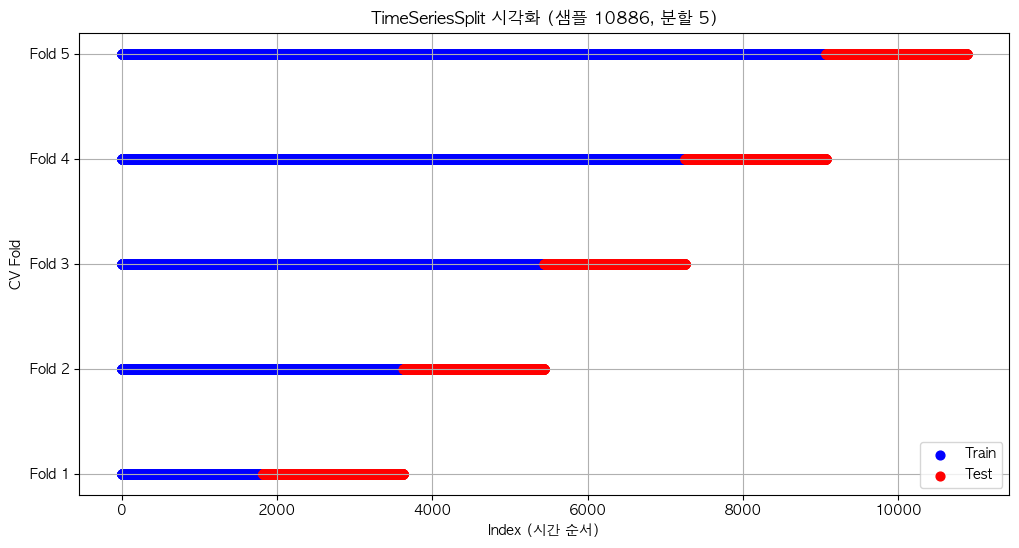

In [7]:
# Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞Ïóê Ï†ÅÏö©Ìï† Í≤ΩÏö∞
plot_timeseries_split(n_samples=X_all_ts.shape[0], n_splits=5)

### 6. ÏïôÏÉÅÎ∏î Î™®Îç∏ÎßÅ (Í∞ÄÏ§ë ÌèâÍ∑†)
- ÏÑ†ÌòïÌöåÍ∑ÄÏôÄ ÎûúÎç§Ìè¨Î†àÏä§Ìä∏Ïùò Í≤ÄÏ¶ù ÏòàÏ∏°ÏùÑ Í∞ÄÏ§ë ÌèâÍ∑†
- Í≤ÄÏ¶ù ÏÑ±Îä•ÏúºÎ°ú Í∞ÄÏ§ëÏπò ÏÑ†ÌÉù ÌõÑ ÌÖåÏä§Ìä∏ ÌèâÍ∞Ä


### 8. Í∞ïÏùò ÏöîÏïΩ Î∞è Îã§Ïùå Îã®Í≥Ñ
- Î™®Îç∏Î≥Ñ ÏßÄÌëú ÎπÑÍµê Î∞è Ìï¥ÏÑù Ï†ïÎ¶¨
- ÏãúÍ≥ÑÏó¥ ÌäπÏÑ±(Í≥ÑÏ†à/Ï∂îÏÑ∏/ÏûêÍ∏∞ÏÉÅÍ¥Ä)ÏùÑ Î∞òÏòÅÌïú Î™®Îç∏ ÏÑ†ÌÉù Í∞ÄÏù¥Îìú
- Îã§Ïùå Í∞ïÏùò: LSTM/Îî•Îü¨Îãù ÌôïÏû• Î∞è ÌïòÏù¥Î∏åÎ¶¨Îìú/ÏïôÏÉÅÎ∏î Í≥†ÎèÑÌôî


In [52]:
import sys, importlib
import numpy as np, pandas as pd
print('py:', sys.executable)
print('numpy:', np.__version__, 'pandas:', pd.__version__)
print('numpy.rec spec:', importlib.util.find_spec('numpy.rec'))
print('numpy.core.records spec:', importlib.util.find_spec('numpy.core.records'))

py: /Users/kimjinseok/Desktop/metacode-lecture/.venv/bin/python
numpy: 1.26.4 pandas: 2.3.2
numpy.rec spec: None
numpy.core.records spec: ModuleSpec(name='numpy.core.records', loader=<_frozen_importlib_external.SourceFileLoader object at 0x11046ebd0>, origin='/Users/kimjinseok/Desktop/metacode-lecture/.venv/lib/python3.12/site-packages/numpy/core/records.py')


In [53]:
# -*- coding: utf-8 -*-
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager

from statsmodels.tsa.seasonal import STL
from statsmodels.nonparametric.smoothers_lowess import lowess

# Ï†ÑÏó≠ Í≤ΩÍ≥† ÏñµÏ†ú (ÎØ∏Îûò/ÌèêÍ∏∞ ÏòàÏ†ï Í≤ΩÍ≥† Î∞è Ìè∞Ìä∏ Í≤ΩÍ≥† ÎÖ∏Ïù¥Ï¶à Ï†úÍ±∞)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message=r"Glyph.*missing from font.*", category=UserWarning)

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï Î∞è ÎßàÏù¥ÎÑàÏä§ Í∏∞Ìò∏ Íπ®Ïßê Î∞©ÏßÄ (ÌõÑÎ≥¥Íµ∞ÏùÑ sans-serif Ïö∞ÏÑ†ÏàúÏúÑÎ°ú ÏßÄÏ†ï)
def _set_korean_font() -> None:
    font_candidates = [
        "AppleGothic",
        "NanumGothic",
        "Malgun Gothic",
        "Noto Sans CJK KR",
        "Noto Sans KR",
        "DejaVu Sans",
    ]
    # Ïö∞ÏÑ†ÏàúÏúÑ Î¶¨Ïä§Ìä∏Î•º Í∑∏ÎåÄÎ°ú Îì±Î°ùÌïòÏó¨ ÏÇ¨Ïö© Í∞ÄÎä•Ìïú Ìï≠Î™©ÏúºÎ°ú ÎåÄÏ≤¥ÎêòÎèÑÎ°ù Ìï®
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = font_candidates
    plt.rcParams["axes.unicode_minus"] = False

_set_korean_font()

# ÎÖ∏Ìä∏Î∂Å Ï†ÑÏ≤¥ ÌëúÏãú ÏòµÏÖò
pd.set_option('display.max_columns', 50)

## Chapter 2-3, 2-2Í∞ï ÏãúÍ≥ÑÏó¥ ÏòàÏ∏° Î™®Îç∏ÎßÅ ‚Äî PyTorch LSTM (Bike Sharing)

- **Î™©Ìëú**: ÏãúÍ≥ÑÏó¥ÏùÑ ÏãúÌÄÄÏä§ ÌòïÌÉúÎ°ú Î≥ÄÌôòÌïòÍ≥† LSTMÏúºÎ°ú ÏòàÏ∏° ÌïôÏäµ/ÌèâÍ∞ÄÌï©ÎãàÎã§.
- **Îç∞Ïù¥ÌÑ∞**: Kaggle Bike Sharing Demand (ÏãúÍ∞Ñ Îã®ÏúÑ, `count` ÎåÄÏÉÅ)
- **Í∑úÏπô(Í∞ïÏùòÏö©)**: `matplotlib`Îßå ÏÇ¨Ïö© (seaborn X), ÏÉâÏÉÅ ÏßÄÏ†ï X, ÏÑúÎ∏åÌîåÎ°Ø X


### 0. ÌôòÍ≤Ω Ï§ÄÎπÑ Î∞è ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏
- PyTorch LSTM Íµ¨ÌòÑ (GPU ÏóÜÏñ¥ÎèÑ CPUÏóêÏÑú ÎèôÏûë)
- Ïû¨ÌòÑÏÑ±ÏùÑ ÏúÑÌïú ÏãúÎìú Í≥†Ï†ï


In [54]:
# -*- coding: utf-8 -*-
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

def _set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)



### 2. ÏãúÌÄÄÏä§ Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ± Î∞è LSTM Î™®Îç∏ Ï†ïÏùò
- ÏúàÎèÑÏö∞ ÌÅ¨Í∏∞ 24(ÌïòÎ£®)Î°ú ÏãúÌÄÄÏä§ Íµ¨ÏÑ±, horizon=1
- Îã®Ïàú LSTM ÌöåÍ∑Ä Ìó§Îìú


### 5. Í∞ïÏùò ÏöîÏïΩ Î∞è Îã§Ïùå Îã®Í≥Ñ
- ÏúàÎèÑÏö∞ Í∏∞Î∞ò ÏãúÌÄÄÏä§ Î™®Îç∏Ïùò Ïû•Îã®Ï†ê
- Î≤†Ïù¥Ïä§ÎùºÏù∏ ÎåÄÎπÑ Í∞úÏÑ† Ìè¨Ïù∏Ìä∏ Î∞è Ï∂îÍ∞Ä Ïã§Ìóò ÏïÑÏù¥ÎîîÏñ¥(Ïä§ÌÉùÎìú LSTM, Dropout, Îã§Ï§ë Ïä§ÌÖù ÏòàÏ∏°)
